In [89]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
import seaborn as sb
import plotly.graph_objects as go
import plotly.express as px


## Описание проекта
Вас пригласили на стажировку в отдел аналитики Яндекс.Афиши. Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.
У вас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Вы изучите:

- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

## Введение

[Шаг 1. Загрузка данных и подготовка их к анализу](#step1).

- Загрузи данные о визитах, заказах и расходах в переменные
- Ознакомление с таблицами
- Предобработка

[Шаг 2. Постройте отчёты и посчитайте метрики](#step2)

- Продукт
  - Сколько людей пользуются в день, неделю, месяц?
  - Сколько сессий в день?
  - Сколько длится одна сессия?
  - Как часто люди возвращаются?

- Продажи

  - Когда люди начинают покупать?
  - Сколько раз покупают за период?
  - Какой средний чек?
  - Сколько денег приносят? (LTV)
- Маркетинг
  - Сколько денег потратили? Всего / на каждый источник / по времени
  - Сколько стоило привлечение одного покупателя из каждого источника?
  - На сколько окупились расходы? (ROI)
        
[Шаг 3. Напишите вывод: порекомендуйте маркетологам, куда и сколько им стоит вкладывать денег?](#step3)

## Шаг 1. Загрузим данные и подготовим их к анализу  <a id="step1"></a> 
</div>


#### Сохраним датафреймы в переменные

In [90]:
visits=pd.read_csv('/datasets/visits_log.csv')
orders=pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

#### Выведем начало таблиц для ознакомления

In [91]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


##### Таблица visits (лог сервера с информацией о посещениях сайта):
    - Uid — уникальный идентификатор пользователя
    - Device — категория устройства пользователя
    - Start Ts — дата и время начала сессии
    - End Ts — дата и время окончания сессии
    - Source Id — идентификатор рекламного источника, из которого пришел пользователь

In [92]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


##### Таблица orders (информация о заказах):
    - Uid — уникальный id пользователя, который сделал заказ
    - Buy Ts — дата и время заказа
    - Revenue — выручка Яндекс.Афиши с этого заказа 

In [93]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


##### Таблица costs (информация о затратах на маркетинг):
    - source_id — идентификатор рекламного источника
    - dt — дата
    - costs — затраты на этот рекламный источник в этот день

#### Посмотрим общую информацию о таблицах

In [94]:
visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


С данными все в порядке, кроме как в столбцах с датами - их мы переведем в нужный формат.
А также изменим регистр названия столбцов.

#### Изменим регистр названия столбцов в таблицах visits и orders

In [95]:
visits.columns = [x.lower() for x in visits.columns]
orders.columns = [x.lower() for x in orders.columns]

Отлично, теперь с данными работать удобнее!

##### Приведем значения во всех 3-х таблицах с датами к формату 'Дата'

In [96]:
visits['start ts'] = pd.to_datetime(visits['start ts'])
visits['end ts'] = pd.to_datetime(visits['end ts'])
orders['buy ts'] = pd.to_datetime(orders['buy ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

#### Выполним проверку

In [97]:
visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end ts       359400 non-null datetime64[ns]
source id    359400 non-null int64
start ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Отлично, теперь с данными можно работать, а приведя названия к нижнему регистру еще и удобнее!

#### Проверим данные на дубликаты

In [98]:
vd = visits.duplicated().sum()
od = orders.duplicated().sum()
cd = costs.duplicated().sum()

print('Количество дубликатов в таблицу visits: {:.2%}'.format(vd))
print('Количество дубликатов в таблицу orders: {:.2%}'.format(od))
print('Количество дубликатов в таблицу costs: {:.2%}'.format(cd))

Количество дубликатов в таблицу visits: 0.00%
Количество дубликатов в таблицу orders: 0.00%
Количество дубликатов в таблицу costs: 0.00%


Супер! В таблицах дубликаты не обнаружены!

## Шаг 2. Постройте отчёты и посчитайте метрики <a id="step2"></a> 
</div>


### 2.1 Распределение трафика по устройствам

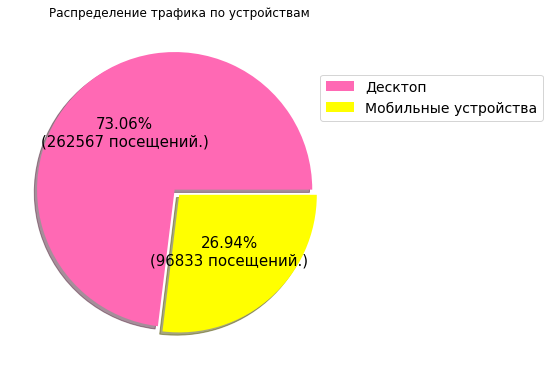

In [99]:
# Сгрупируем данные
visits_by_device = visits.groupby('device').agg({'uid': 'count'})
summary = visits_by_device.values.sum()

# Напишем функцию для подсчета процентовки

def func_pct(pct):
    value = float(pct/100.*summary)
    #mean = visits_by_device.mean()
    return "{:.2f}%\n({:.0f} посещений.)".format(pct, value)

explode = (0.05, 0)

# Оформим график

ax_pie = visits_by_device.plot(kind='pie',
                               y='uid',
                               fontsize=15, 
                               use_index=False,
                               shadow=True,
                               explode=explode,
                               title = 'Распределение трафика по устройствам',
                               pctdistance=0.55,
                               figsize=(15,5), 
                               autopct=lambda pct: func_pct(pct),
                               colors=['#FF69B4',
                                       '#FFFF00'],
                               labels=None)

plt.tight_layout(pad=0)

legend = ax_pie.legend(['Десктоп',
                        'Мобильные устройства'], 
                       bbox_to_anchor=(0.89,0.87), 
                       prop={'size':14})

y_label = ax_pie.set_ylabel('')

Странно, но мы видим, что Десктоп занимает почти 3/4 всего объема трафика! И это не смотря на то, что на дворе 2018 год, и уже все обзавелись смартфонами.

### 2.2 Продукт

#### Сколько людей пользуются в день, неделю, месяц?

In [100]:
# Добавим столбец duration для определения длины сессии в секундах к таблице visits

visits['duration'] = (visits['end ts'] - visits['start ts']).dt.seconds

# Добавим столбцы с днями, неделями и годом 1 сессии 

visits['start_ts_day'] = visits['start ts'].dt.date
visits['start_ts_week'] = pd.DatetimeIndex(visits['start ts']).week
visits['start_ts_month'] = pd.DatetimeIndex(visits['start ts']).month
visits['start_ts_year'] = pd.DatetimeIndex(visits['start ts']).year

# Рассчитаем сколько людей пользуются в день, неделю, месяц

dau = visits.groupby(['start_ts_day']).agg({'uid':'nunique'}).mean()
wau = visits.groupby(['start_ts_year', 'start_ts_week']).agg({'uid':'nunique'}).mean()
mau = visits.groupby(['start_ts_year', 'start_ts_month']).agg({'uid':'nunique'}).mean()
print('За день сервисом в среднем пользуются {} людей'.format(int(dau)))
print('За неделю сервисом в среднем пользуются {} людей'.format(int(wau)))
print('За месяц сервисом в среднем пользуются {} людей'.format(int(mau)))

# Расчитаем недельную и месячную вовлеченность аудитории

sticky_wau = dau / wau
sticky_mau = dau / mau
print('Недельная вовлеченность аудитории: {:.2%}'.format(sticky_wau[0]))
print('Месячная вовлеченность аудитории: {:.2%}'.format(sticky_mau[0]))
print('''Видим, что вовлеченность аудитории не высокая, очевидно, что сервисом пользуются редко.''')

За день сервисом в среднем пользуются 907 людей
За неделю сервисом в среднем пользуются 5716 людей
За месяц сервисом в среднем пользуются 23228 людей
Недельная вовлеченность аудитории: 15.88%
Месячная вовлеченность аудитории: 3.91%
Видим, что вовлеченность аудитории не высокая, очевидно, что сервисом пользуются редко.


#### Количество сессий в день

In [101]:
day_visits = visits.groupby(['start_ts_day']).agg({'uid':'count'})
day_visits_d = visits.query('device == "desktop"').groupby(['start_ts_day']).agg({'uid':'count'})
day_visits_t = visits.query('device == "touch"').groupby(['start_ts_day']).agg({'uid':'count'})
print('В среднем в день проходит {} сессий'.format(int(day_visits.mean()[0])))
print('В среднем по устройству десктоп в день проходит {} сессий' .format(int(day_visits_d.mean()[0])))
print('В среднем по мобильным устройствам в день проходит {} сессий' .format(int(day_visits_t.mean()[0])))

В среднем в день проходит 987 сессий
В среднем по устройству десктоп в день проходит 721 сессий
В среднем по мобильным устройствам в день проходит 266 сессий


Около 75% заходят на сайт с ПК

#### Сколько длится одна сессия?

(0, 2000)

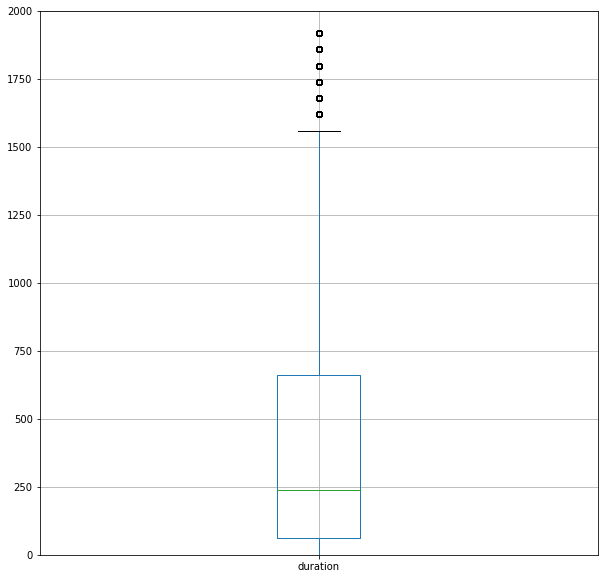

In [102]:
# Напишем функцию для очистки данных от выбросов

def vybros(df, column,graphic=0,x=10,y=10):
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    filt = (df[column] >= (q1 - 1.5*iqr)) & (df[column] <= (q3 + 1.5*iqr))
    if graphic == 1:
        return df.loc[filt].boxplot([column],
                                    figsize=(x,y))
    else:
        return df.loc[filt]

# Построим график для средней продолжительность сессии с применением функции

vybros(visits,
       'duration',
       1,10,10).set_ylim(0,2000)    

В большинство пользователей проводит на сайте от 50 до 600 секунд, медианное значение находится на отметке 240 секунд - вполне нормальное время для того, чтобы найти интересующее мероприятие и купить билет)

##### Время сессии для мобильных и ПК устройств

(0, 2000)

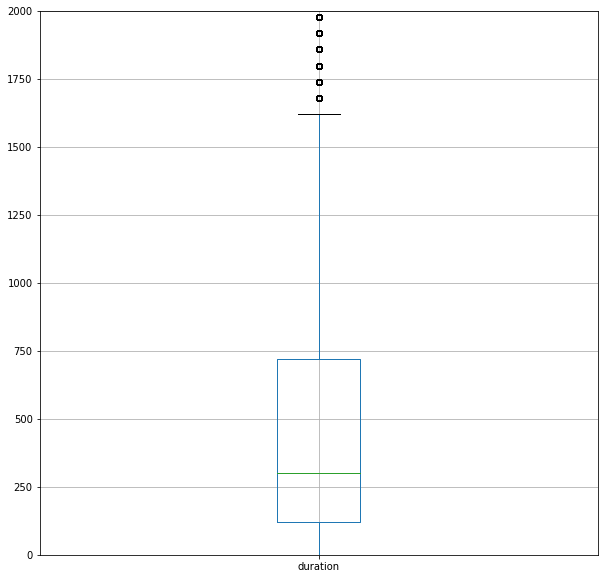

In [103]:
# Отфильтруем датафрейм по типам устройств

# Датафрейм только с ПК

visits_pc = visits.query('device == "desktop"')

vybros(visits_pc,
       'duration',
       1,10,10).set_ylim(0,2000) 

(0, 1500)

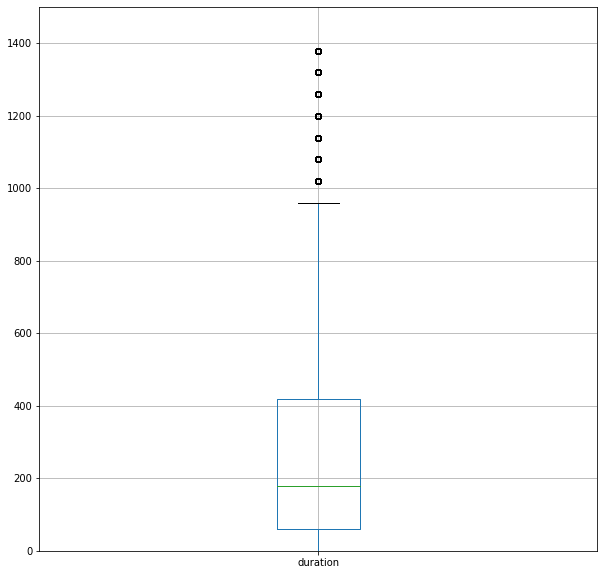

In [104]:
# Датафрейм только с мобильными устройствами

visits_mobile = visits.query('device == "touch"')

vybros(visits_mobile,
       'duration',
       1,10,10).set_ylim(0,1500)

#### Как часто люди возвращаются?

In [105]:
# Разделим общее количество визитов на число уникальных пользователей

sessions_unique = len(visits) / len(visits['uid'].unique())
print('В среднем на одного пользователя приходится {:.2f} сессий \n'.format(sessions_unique))

В среднем на одного пользователя приходится 1.58 сессий 



Теперь построим Retention Rate, чтобы узнать, как часто возвращаются пользователи в рамках когорт

In [106]:
# Найдем дату первой активности на сайте для каждого пользователя

first_activity = visits.groupby('uid').agg({'start ts':'min'})
first_activity.columns = ['first_activity']
visits = visits.join(first_activity, on='uid')

Отлично! Теперь у нас есть дата начала пользования сервисом

In [107]:
# Отфильтруем таблицу с нуджными нам данными

visits_filt = visits[['uid',
                      'first_activity',
                      'start ts']]

# Добавим столбцы с датой первой активности (['first_activity_month']), датой посещения (['start_ts_month'])
# и период "жизни" клиента (['lifetime'])

visits_filt['first_activity_month'] = visits_filt['first_activity'].astype('datetime64[M]')
visits_filt['start_ts_month'] = visits_filt['start ts'].astype('datetime64[M]')
visits_filt['lifetime'] = ((visits_filt['start_ts_month'] - visits_filt['first_activity_month'])
                         / np.timedelta64(1, 'M')).round().astype('int')

# Создадим когорту по месяцу 1 первой активности и периоду жизни клиента

cohorts_visits = visits_filt.groupby(['first_activity_month', 'lifetime']).agg({'uid':'nunique'}).reset_index()

users_count = cohorts_visits[cohorts_visits['lifetime'] == 0][['first_activity_month', 'uid']]
users_count.columns = ['first_activity_month', 'cohort_users']
users_count = users_count.set_index('first_activity_month')                                           

In [108]:
# Объеденим таблицы cohorts_visits и users_count
                                            
cohorts_visits = cohorts_visits.join(users_count, on = 'first_activity_month')

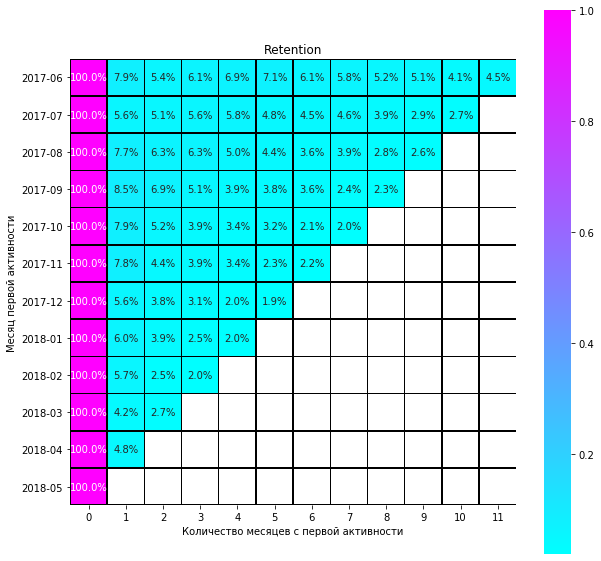

In [109]:
# Добавим новый столбец 'retention'
                                            
cohorts_visits['retention'] = cohorts_visits['uid'] / cohorts_visits['cohort_users']

# Создадим сводную таблицу  

retention_pivot = cohorts_visits.pivot_table(index='first_activity_month',
                                      columns='lifetime',
                                      values='retention',
                                      aggfunc='sum')

retention_pivot = retention_pivot.reset_index()
retention_pivot['first_activity_month'] = retention_pivot['first_activity_month'].dt.strftime('%Y-%m')
retention_pivot = retention_pivot.set_index('first_activity_month')
retention_pivot

# Построим график heatmap

plt.figure(figsize=(10, 10))
plt.title('Retention')

sns.heatmap(retention_pivot,
            annot=True,
            fmt=".1%",
            linewidths=.5,
            linecolor='black',
            square=True,
            cmap = 'cool')

plt.ylabel('Месяц первой активности')
plt.xlabel('Количество месяцев с первой активности')
plt.show()

Возвращаемость пользователя на сервис крайне низкая. Самой "живучей" когортой стала когорта "2017-06" - ее retention и падал и старался подняться до прежних максимальных значений, и в итоге ослаб не так сильно, как другие когорты. Возможно у этой когорты есть какие-то спец условия на покупку билетов или другие преимущества. Остальные когорты возможно пользуются разными агрегаторами, или вообще редко покупают билеты онлайн, или покупают только в период акций скидок или эксклюзивности агрегатора на распространение билетов какого-либо меприятия

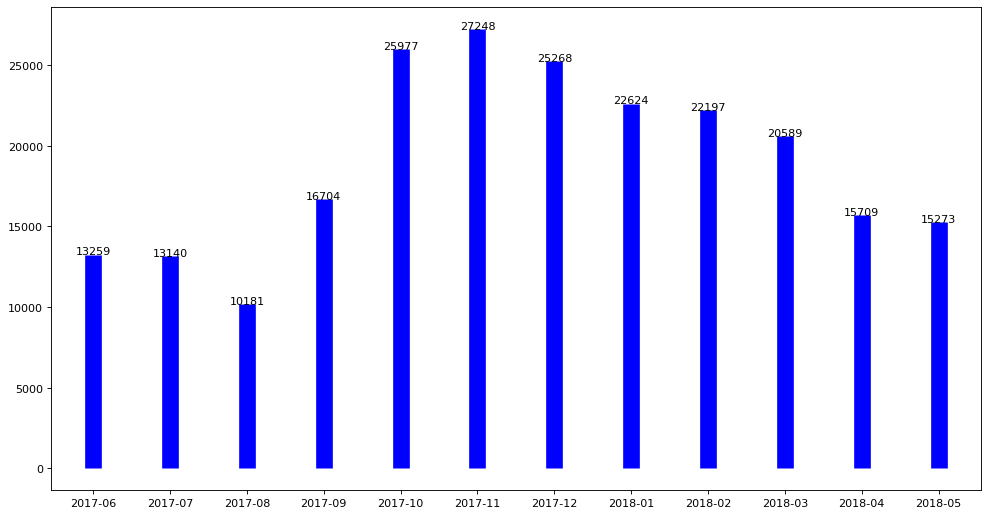

In [110]:
# Посмотрим количества новых пользователей по месяцам

cohorts_visits['first_activity_month'] = cohorts_visits['first_activity_month'].dt.strftime('%Y-%m')
cohorts_visits = cohorts_visits.set_index('first_activity_month')
new_users_by_month = cohorts_visits[cohorts_visits['lifetime'] == 0][['cohort_users']]

# Выведем график 
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(15,8),
                       facecolor='white',
                       dpi= 80)

ax.vlines(x=new_users_by_month.index,
          ymin=0,
          ymax=new_users_by_month.cohort_users,
          color='blue',
          alpha=1,
          linewidth=15)

for i, cohort_users in enumerate(new_users_by_month.cohort_users):
    ax.text(i,
            cohort_users+1,
            round(cohort_users, 1),
            horizontalalignment='center')
plt.show()

#### Вывод

В общем по продукту можно сделать следующие выводы:

- Сколько людей пользуются в день, неделю, месяц?

  - За день сервисом в среднем пользуются 907 людей
  - За неделю сервисом в среднем пользуются 5716 людей
  - За месяц сервисом в среднем пользуются 23228 людей
  - Недельная вовлеченность аудитории: 15.88%
  - Месячная вовлеченность аудитории: 3.91%
Видно, что вовлеченность аудитории низкая и сервисом пользуются редко. Но это нормально, так как человек не посещает концерты или театры каждую неделю или даже месяц
        
- Количество сессий в день
    - В среднем в день проходит 987 сессий - много ли это или мало судить сложно, но оценивая рынок развлечений, то есть куда расти, стоит увеличивать интерес к платформе
    
    - В среднем по устройству десктоп в день проходит 721 сессий, что составляет 75 % от общего трафика. Опять же, учитывая область иследований в разрезе 2018-2019 годов, стоит предположить, что мобильный трафик уже сравнялся с трафиком на ПК, и стоит уделить внимание на разработку приложения
    
    - В среднем по мобильным устройствам в день проходит 266 сессий - по трафику для этого типа устройств явно есть куда расти
        
   - Как часто люди возвращаются?
    
- Показатель возвращаемости клиентов на сервис низкий - пользователи редко возвращаются на сервис. Они могут просто забыть о его существовании или им не понравился сервисюё. Здесь можно задать вопрос клиентской службе и маркетолагам - почему к нам не приходят снова?
 
- Максимальное число новых пользователей сервис набрал в ноябре - около 22 тысяч. В осенне-зимний период сервис уверенно набирал новых пользователей, но с наступлением весны прирост утих. Связанно это с временем года и сезонностью большинства мероприятий в сфере культуры

## 2.2  Продажи

#### Когда люди начинают покупать?

In [111]:
# Найдём время и дату первой сессии и сохраним в переменную first_s

first_s = visits.groupby(['uid']).agg({'start ts':'min', 'source id':'first'})
first_s.columns = ['first_activity', 'first_source']

# Найдем время первой покупки и сохраним в переменную first_o

first_o = orders.groupby(['uid']).agg({'buy ts':'min'})
first_o.columns = ['first_buy_ts']

# Соединим таблицы first_o и first_s 

first_o = first_o.join(first_s,on='uid')

Отлично! теперь у нас есть данные по дате активности и дате первой покупки

In [112]:
# Расчитаем время между первой покупкой и первой сессии, и сохраним в cтолбец time_f_p

first_o['time_f_p'] = (first_o['first_buy_ts'] - 
                                          first_o['first_activity']) / np.timedelta64(1, 'm')

(0, 100)

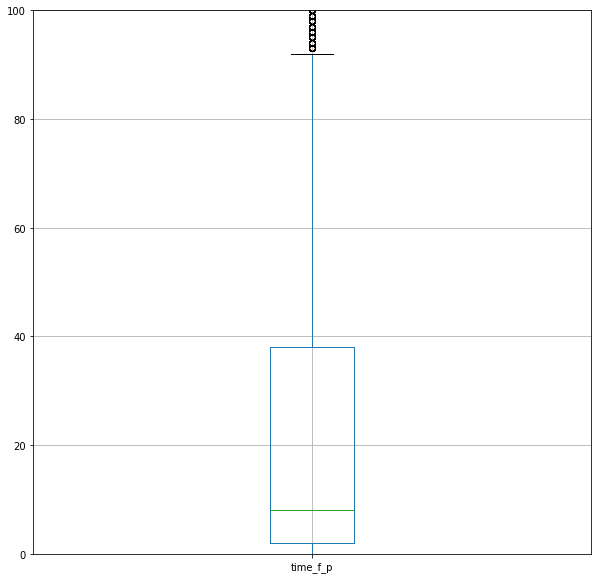

In [113]:
# Построим график разницы первой покупкой и первой активностью без учета выбросов

vybros(first_o,'time_f_p',1,10,10).set_ylim(0,100)

Основные значения разницы во времени между первой покупкой и первой сессии лежат в диапозоне от 2 до 38 минут. Вполне реальные для сервиса агрегатора билетов - какие-то клиенты точно знают на какое мероприятие хотят купить билет, а для кого-то выбор мероприятия занятие не из простых и им требуется больше времени с перерывом на чай). Среднее значение во времени между первой покупкой и первой сессии - 7 минут, что тоже вполне реальная цифра.

#### Сколько раз покупают за период?

In [114]:
# Посчитаем даты заказов и активностей

orders = orders.join(first_o, on='uid')

orders['first_buy_month'] = orders['first_buy_ts'].astype('datetime64[M]')
orders['first_session_month'] = orders['first_activity'].astype('datetime64[M]')
orders['buy_month'] = orders['buy ts'].astype('datetime64[M]')
orders['buy_date'] = orders['buy ts'].dt.date
orders['buy_week'] = orders['buy ts'].dt.week
orders['buy_year'] = orders['buy ts'].dt.year
orders.head()

,buy ts,revenue,uid,first_buy_ts,first_activity,first_source,time_f_p,first_buy_month,first_session_month,buy_month,buy_date,buy_week,buy_year
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:09:00,1,1.0,2017-06-01,2017-06-01,2017-06-01,2017-06-01,22,2017
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:14:00,2,11.0,2017-06-01,2017-06-01,2017-06-01,2017-06-01,22,2017
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:25:00,2,2.0,2017-06-01,2017-06-01,2017-06-01,2017-06-01,22,2017
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:14:00,2,15.0,2017-06-01,2017-06-01,2017-06-01,2017-06-01,22,2017
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:31:00,3,27.0,2017-06-01,2017-06-01,2017-06-01,2017-06-01,22,2017


Теперь у нас есть вся необходимая информация расчета количества покупок по периодам

In [115]:
day_purchases = orders.groupby(['buy_date', 'uid']).agg({'buy ts':'count'}).mean()[0]
week_purchases = orders.groupby(['buy_year', 'buy_week', 'uid']).agg({'buy ts':'count'}).mean()[0]
month_purchases = orders.groupby(['buy_month', 'uid']).agg({'buy ts':'count'}).mean()[0]
year_purchases = orders.groupby(['buy_year', 'uid']).agg({'buy ts':'count'}).mean()[0]
print('''В среднем на одного пользователя приходится:
Покупок в день - {:.2f},
Покупок в неделю - {:.2f},
Покупок в месяц - {:.2f},
В год - {:.2f}'''.format(day_purchases, week_purchases, month_purchases, year_purchases))

В среднем на одного пользователя приходится:
Покупок в день - 1.08,
Покупок в неделю - 1.16,
Покупок в месяц - 1.23,
В год - 1.32


Если количество покупок в день, неделю и даже в месяц меня не особо смущает, то количество покупок в год...результат крайне низкий. Пользователь покупает практически один раз и забывает про сервис, и не возвращается( Надо работать над удержанием клиента - концерты, новые фильмы и спектали выходят каждый месяц, а не раз в год.

#### Анализ по количеству покупок на пользователя по когортам

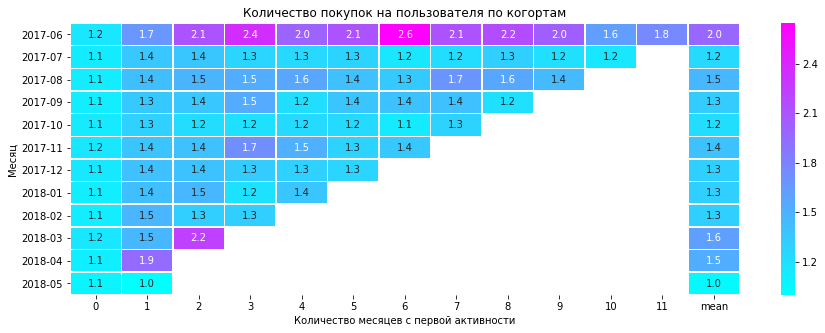

In [116]:
# Отфильтрем таблицу только по нудным данным

orders = orders[['uid',
                 'revenue',
                 'buy ts',
                 'buy_month',
                 'first_buy_ts',
                 'first_buy_month',
                 'first_session_month']]

# Посчитаем lifetime заказов

orders['lifetime_pur'] = ((orders['buy_month'] - orders['first_session_month']) 
                           / np.timedelta64(1, 'M')).round().astype('int')

# Сгруппируем заказы по когортам и lifetime и высчитаем количество покупок и пользователей

orders_group_cohorts = orders.groupby(['first_session_month', 
                                            'lifetime_pur']).agg({'uid':['count', 'nunique']}).reset_index()

orders_group_cohorts.columns = ['first_session_month', 'lifetime_pur', 'n_orders', 'n_users']

# Расчитаем количество заказов на одного пользователя по когорте и lifetime

orders_group_cohorts['orders_per_user'] = orders_group_cohorts['n_orders']/ orders_group_cohorts['n_users']
orders_group_cohorts['first_session_month'] = orders_group_cohorts['first_session_month'].dt.strftime('%Y-%m')

# Создадим сводную таблицу с когортным анализом количества заказов на пользователя 

cohorts = orders_group_cohorts.pivot_table(index = 'first_session_month',
                                                columns = 'lifetime_pur', 
                                                values = 'orders_per_user',
                                                aggfunc = 'mean')

#  Добавим столбец со средними значениями купленных билетов на пользователя

cohorts['mean'] = cohorts.mean(axis=1)

# Выведем график 

plt.figure(figsize=(15, 5))
plt.title('Количество покупок на пользователя по когортам')

sns.heatmap(cohorts,
            annot=True,
            fmt=".1f",
            linewidths=.5,
            cmap = 'cool')

plt.xlabel('Количество месяцев с первой активности')
plt.ylabel('Месяц первой активности')
plt.ylabel('Месяц')
plt.show()

Снова выделяются пользователи первый когорты "2017-06" -  в большинстве случаев в месяц совершают в среднем чуть более 2-ух покупок и более лояльны к сервису, чем остальные... у них явно есть какие-то бонусы)
Показатели остальных когорт хуже, но у когорт 2018-04 и 2018-05 есть потецниал стать не плохими клиентами, хоть они и новые и информации о покупках о них, мягко говоря, не много, но есть надежды на приблизиться к показатедям когорты "2017-06", надо обратить внимание на них , но и также постараться реанимировать и подтолкнуть к использованию сервиса снова остальные когорты.

#### Средний чек

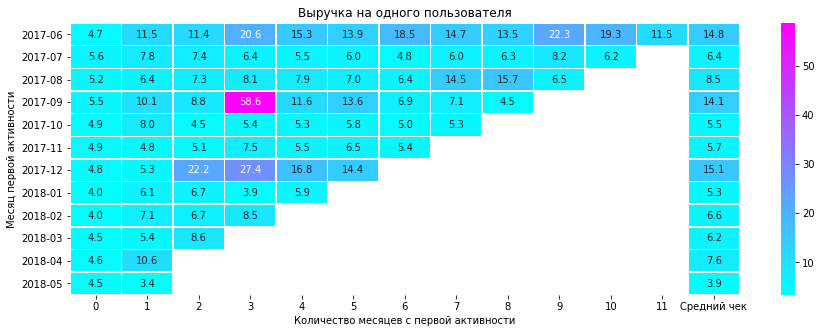

In [117]:
# Построим сводную таблицу по покупкам по когортам, lifetime и суммам покупок на одного пользователя

orders_group_cohorts = orders.groupby(['first_session_month',
                                       'lifetime_pur']).agg({'revenue':'sum', 'uid':'nunique'}).reset_index()

orders_group_cohorts.columns = ['first_session_month',
                                'lifetime_pur',
                                'revenue_total', 
                                'n_users']

# Оставим только год и месяц для когорты

orders_group_cohorts['first_session_month'] = orders_group_cohorts['first_session_month'].dt.strftime('%Y-%m')

# Посчитаем выручку на каждогопользователя и сохраним в столбец revenue_per_user 

orders_group_cohorts['revenue_per_user'] = orders_group_cohorts['revenue_total'] / orders_group_cohorts['n_users']

# Создадим сводную таблицу с когортным анализом суммы покупок на пользователя 

cohorts_r_user = orders_group_cohorts.pivot_table(index = 'first_session_month', 
                                                  columns = 'lifetime_pur', 
                                                  values = 'revenue_per_user', 
                                                  aggfunc = 'mean')
# Добавим столбец со средней выручкой по когорте
cohorts_r_user['Средний чек'] = cohorts_r_user.mean(axis=1)

# Выведем график

plt.figure(figsize=(15, 5))
plt.title('Выручка на одного пользователя')

sns.heatmap(cohorts_r_user,
            annot=True,
            fmt=".1f",
            linewidths=.5,
            cmap = 'cool')

plt.xlabel('Количество месяцев с первой активности')
plt.ylabel('Месяц первой активности')
plt.show()


Ну что-ж, показатели по когортам не однозначные, какого-то общего тренда не наблюдается. Хорошие показатели все также у когорты "2017-06" - со средним значением 14.8 у.е. на пользователя, но в этот раз 1 место занимает когорты "2017-12" - пользователей этой когорты интересовали весенние мероприятия. Когорта "2017-09" также имеет хорошие показатели - пользователи этой когорты активно скупали билета, и скорее всего на Новогоднии праздники.

(0, 20)

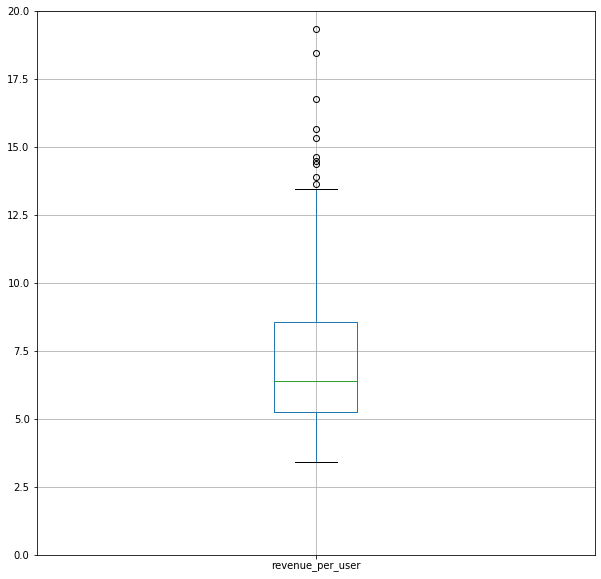

In [118]:
# Построим на средний чек на графике

vybros(orders_group_cohorts,
       'revenue_per_user',
       1,10,10).set_ylim(0,20)

В большинстве случаев стоимость одного билета составляет от 5 до 8.5 у.е, за исключением дорогих мероприятий или сверх дешевых билетов, и могу предположить, что это стоимость билета в кино. Так как основные значения лежат в этом диапозоне, можно выдвинуть предложения, что клиентов сервиса интресует покупка блилетов именно на сеансы в  кино.
При этом в среднем тратят около 6 у.е.

#### Сколько денег приносят? (LTV)

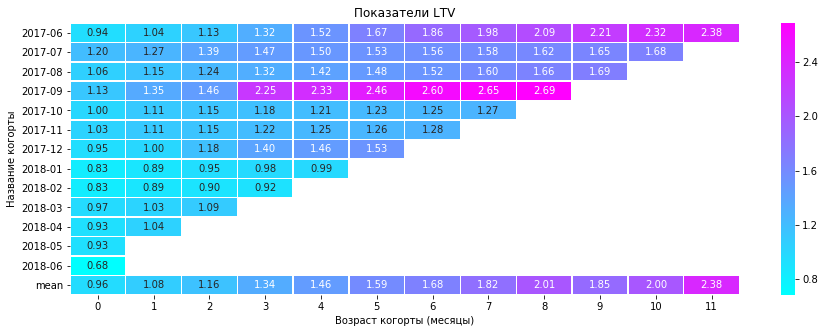

In [119]:
# Расчитаем "возраст" когорт по месяцам

orders['age_cohort'] = ((orders['buy_month'] 
                         - orders['first_buy_month']) / np.timedelta64(1, 'M')).round().astype('int')

# Посчитаем количество уникальных пользователей на каждый конкретный день по когорте

cohort_count = orders.groupby('first_buy_month').agg({'uid':'nunique'})

cohort_count.columns = ['cohort_count']

# Соберем сводную таблицу и объединим с cohort_count

orders_grouped_ltv = orders.groupby(['first_buy_month', 
                                    'age_cohort']).agg({'revenue':'sum',
                                                        'uid':'nunique'}).reset_index()

orders_grouped_ltv = orders_grouped_ltv.join(cohort_count, on='first_buy_month')


# Добавим столбец c расчетом ltv для когорт
# Так как условием не задан margin_rate, а Яндекс афиша является агрегатором, то могу предположить,
# что в лучшем случае margin_rate = 0.2

margin_rate = 0.2

    # Рассчитаем валовую прибыль 

orders_grouped_ltv['gp'] = orders_grouped_ltv['revenue']* margin_rate
    
    # Рассчитаем ltv

orders_grouped_ltv['ltv'] = orders_grouped_ltv['gp']/ orders_grouped_ltv['cohort_count']


# Соберем сводную таблицу 

ltv = orders_grouped_ltv.pivot_table(index = 'first_buy_month', 
                                     columns = 'age_cohort', 
                                     values = 'ltv', 
                                     aggfunc = 'mean')
# Произведем рассчет ltv 

ltv = ltv.cumsum(axis = 1)
ltv = ltv.reset_index()
ltv['first_buy_month'] = ltv['first_buy_month'].dt.strftime('%Y-%m')
ltv = ltv.set_index('first_buy_month')

# Добавим средние значения ltv по месяцам

ltv.loc['mean'] = ltv.mean()

# Выведем когоротгый анализ на экран 

plt.figure(figsize=(15, 5))
plt.title('Показатели LTV')

sns.heatmap(ltv,
            annot=True,
            fmt=".2f",
            linewidths=.5,
            cmap = 'cool')

plt.xlabel('Возраст когорты (месяцы)')
plt.ylabel('Название когорты')
plt.show()

Приятно видеть, что пользователи продолжают пользоваться и совершать покупки на сервисе, но рост ltv идет медленно...
Надо мотивировать пользователя на совершение покупок - может сделать рассылку с анонсами на будующие меропрития?

In [120]:
# Посмотрим на общую выручку по когортам
orders_grouped_ltv['first_buy_month'] = orders_grouped_ltv['first_buy_month'].dt.strftime('%Y-%m')

gp1 = orders_grouped_ltv.pivot_table(index = 'first_buy_month',  
                                               values = 'gp', 
                                               aggfunc = 'sum')

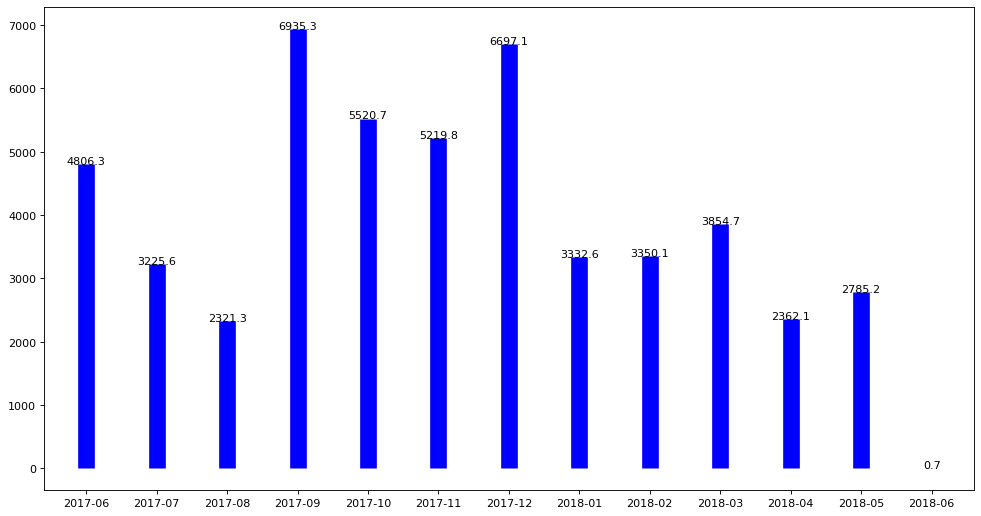

In [121]:
# Выведем график 

import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(15,8),
                       facecolor='white',
                       dpi= 80)

ax.vlines(x=gp1.index,
          ymin=0,
          ymax=gp1.gp,
          color='blue',
          alpha=1,
          linewidth=15)

for i, gp in enumerate(gp1.gp):
    ax.text(i,
            gp+1,
            round(gp, 1),
            horizontalalignment='center')

plt.show()

Максимальную выручку мы наблюдаем в период с сентября по декбрь, далее выручка падает 50%. Объясняется это спросом на культурные мероприятия, ведь осенью и зимой варианты досуга сокращаются ввиду ухудшающихся погодных условий, а после нового года наступает "спящий период", когда экономическая активностей во всех розничных сферах сокращается -такой тренд!

### Вывод

- Когда люди начинают покупать?
    - Основные значения разницы во времени между первой покупкой и первой сессии лежат в диапозоне от 2 до 38 минут.Среднее значение во времени между первой покупкой и первой сессии - 7 минут, что тоже вполне реальная цифра.
- Сколько раз покупают за период
   - В среднем на одного пользователя приходится:
       - Покупок в день - 1.08,
       - Покупок в неделю - 1.16,
       - Покупок в месяц - 1.23,
       - В год - 1.32
- Средний чек
    - В большинстве случаев стоимость покупки составляет от 5 до 8.5 у.е. 
    - В среднем тратят около 6 у.е.
- Сколько денег приносят? (LTV)
    - В большинсте больше 50% прибыли клиенты приносят в первый месяц с покупки, далее рост выручки на клиента снижается

## Маркетинг

#### Сколько денег потратили? Всего / на каждый источник / по времени

##### Сколько денег потратили всего

In [122]:
# Посчитаем общие затраты на маркетинг 

costs['cost_month'] = costs['dt'].astype('datetime64[M]')
costs['cost_month'] = costs['cost_month'].dt.strftime('%Y-%m')
print('Всего потрачено на маркетинг {} у.е.'.format(costs['costs'].sum()))

Всего потрачено на маркетинг 329131.62 у.е.


##### Сколько денег потратили на каждый источник

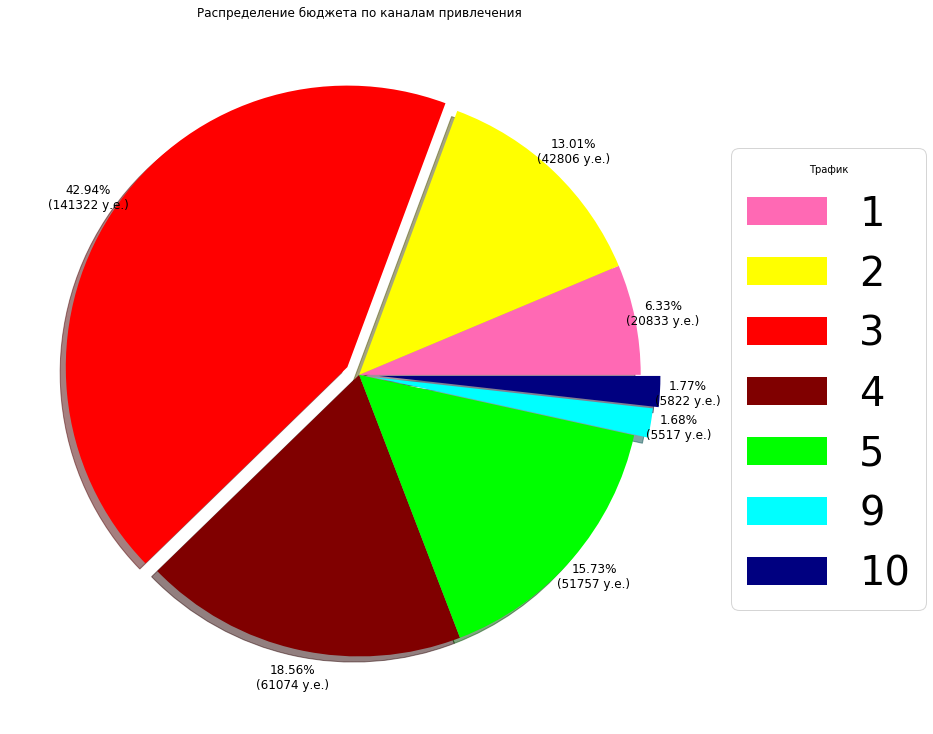

In [123]:
# Сгрупируем данные
costs_g = costs.groupby('source_id').sum()
summary = costs['costs'].sum()

# Напишем функцию для подсчета процентовки

def func_pct(pct):
    value = float(pct/100.*summary)
    return "{:.2f}%\n({:.0f} у.е.)".format(pct, value)

explode = (0,
           0,
           0.05,
           0,
           0,
           0.05,
           0.07)

# Оформим график

ax_pie = costs_g.plot(kind='pie',
                      y='costs',
                      fontsize=12,
                      use_index=False,
                      shadow=True,
                      explode=explode,
                      title = 'Распределение бюджета по каналам привлечения',
                      pctdistance=1.1,
                      figsize=(20,10), 
                      autopct=lambda pct: func_pct(pct),
                      colors=['#FF69B4',
                              '#FFFF00',
                              '#FF0000',
                              '#800000',
                              '#00FF00',
                              '#00FFFF',
                              '#000080'],
                               labels=None)

plt.tight_layout(pad=0)

legend = ax_pie.legend(['1','2','3','4','5','9','10'],
                       bbox_to_anchor=(1,0.85), 
                       prop={'size':40},
                       title= 'Трафик')

y_label = ax_pie.set_ylabel('')

 Львиная доля бюджета распределена между 3,4 и 5 каналом трафика, далее рассмотрим их эффективность

##### Сколько денег потратили по времени

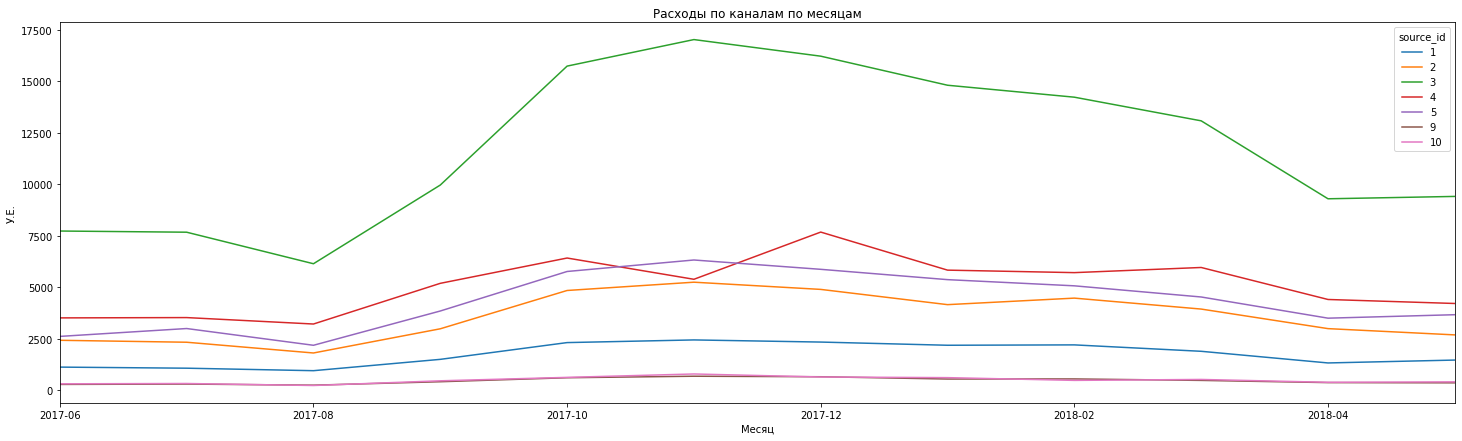

In [124]:
# Выведем график для каждого канала с расходами по месяцам

costs_pivot = costs.pivot_table(index = 'cost_month',
                                columns = 'source_id',
                                values = 'costs',
                                aggfunc = 'sum')

costs_pivot.plot(figsize = (25,7),
                 title = 'Расходы по каналам по месяцам')

plt.xlabel('Месяц')
plt.ylabel('У.Е.')
plt.show()

Здесь никаких сюрпризов - с наступлением осени, когда на уличе погода, повышается и спрос на оффлайн мероприятия под крышей, следственно влияния в рекламу начинают расти с сентября и понижаться маю

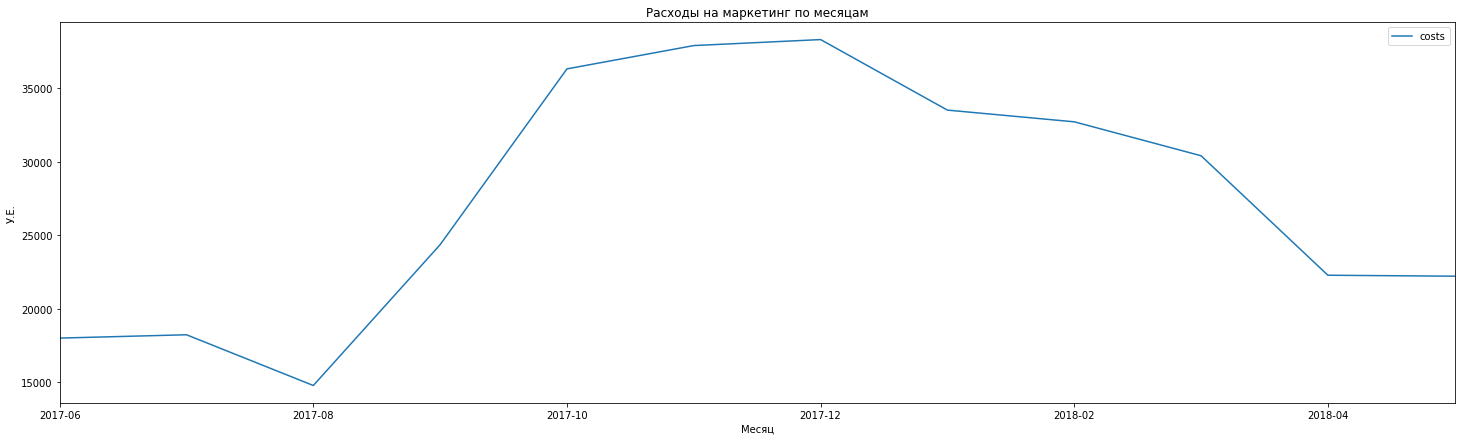

In [125]:
# Выведем график с общими расходами по месяцам

costs.pivot_table(index = 'cost_month',
                  values ='costs',
                  aggfunc = 'sum').plot(title = 'Расходы на маркетинг по месяцам',
                                        figsize = (25,7))

plt.xlabel('Месяц')
plt.ylabel('У.Е.')
plt.show()

#### Сколько стоило привлечение одного покупателя из каждого источника?

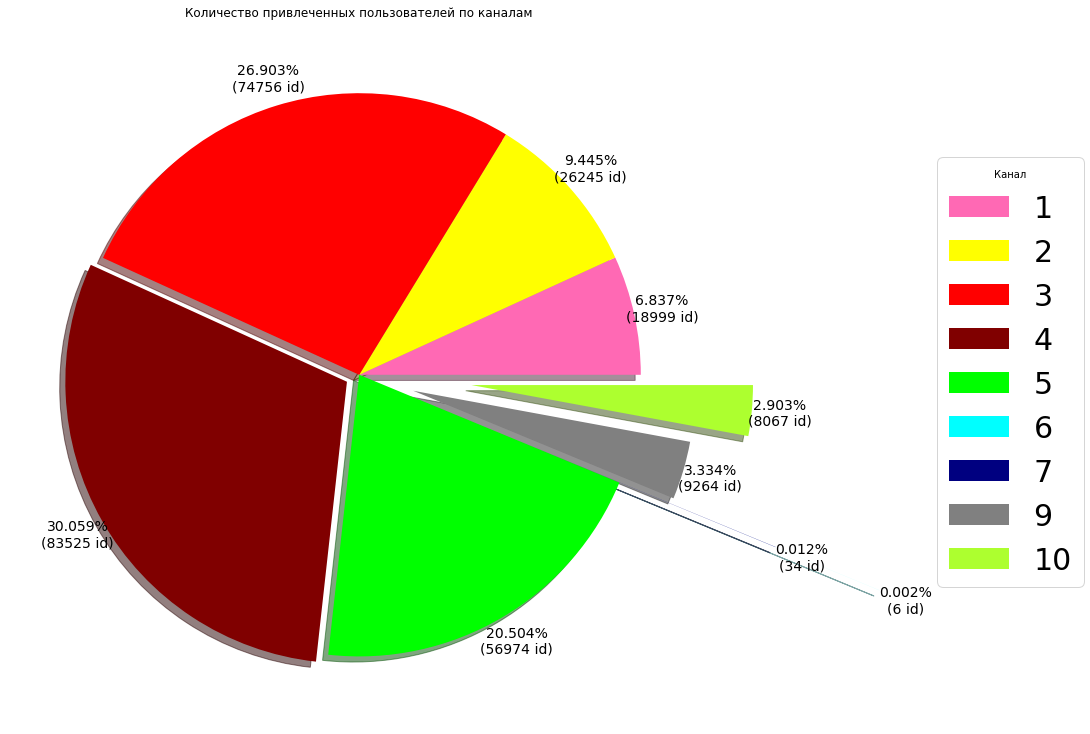

In [126]:
# Cгрупируем данные для подсчета количества пришедших пользователей с кажого канала

visits_u = visits.groupby('source id').agg({'uid': 'nunique'})
summary = visits_u['uid'].sum()

# Напишем функцию для подсчета процентовки

def func_pct(pct):
    value = float(pct/100.*summary)
    #mean = visits_by_device.mean()
    return "{:.3f}%\n({:.0f} id)".format(pct, value)

explode = (0,0,0,0.05,0,1,0.6,0.2,0.4)

# Оформим график

ax_pie = visits_u.plot(kind='pie',
                       y='uid',
                       fontsize=14,
                       use_index=False,
                       shadow=True, 
                       explode=explode,
                       title = 'Количество привлеченных пользователей по каналам',
                       pctdistance=1.1,
                       figsize=(20,10),
                       autopct=lambda pct: func_pct(pct), 
                       colors=['#FF69B4',
                               '#FFFF00',
                               '#FF0000',
                               '#800000',
                               '#00FF00',
                               '#00FFFF',
                               '#000080',
                               '#808080',
                               '#ADFF2F'],
                       labels=None)

plt.tight_layout(pad=0)

legend = ax_pie.legend(['1','2','3','4','5','6','7','9','10'], 
                       bbox_to_anchor=(1.3,0.83),
                       prop={'size':30},
                       title= 'Канал',)

y_label = ax_pie.set_ylabel('')

А вот здесь уже интресней! Не смотря на то, что на на канал 3 пришлось 43 % рекламных расходов, по нему пришло почти на 10 тысяч человек меньше, чем по каналу 3, при том, что канал 4 обошелся почти в 2,5 раза дешевле. Следует обратить внимание на канал 3 по сточимости привлечения на сайт потенциальных клиентов. Но самое главное это эффективность в деньгах, рассмотрим ее ниже

#### Сгрупируем новую таблицу для расчета cac, ltv и roi

In [127]:
o1 = orders.groupby('uid')['revenue'].sum().reset_index()
o2 = visits.copy()
# Добавим к uid в visits(o2) общую сумму их покупок
o2 = o2.merge(o1, on ='uid')
# Сгруппируем o2 по uid и выведем первую сессию 
o3 = o2.groupby('uid')['start ts'].min().reset_index()
# Соеденим о2 и о3 по uid и мин.сессии методом inner
o4 = o2.merge(o3, on = ['uid','start ts'], how = 'inner')

In [128]:
revenue_group = o4.groupby('source id')['revenue'].sum().reset_index()
costs_group = costs.groupby('source_id')['costs'].sum().reset_index()
costs_group = costs_group.rename(columns={'source_id': 'source id'})
source_group = o4.groupby('source id')['uid'].nunique().reset_index()
costs_group = costs_group.merge(source_group,on = 'source id')
costs_group['cost_per_user'] = costs_group['costs'] / costs_group['uid']
costs_group = costs_group.merge(revenue_group,on = 'source id')

In [129]:
costs_group['gp'] = costs_group['revenue'] * margin_rate
costs_group['ltv'] = costs_group['gp'] / costs_group['uid']
costs_group['roi'] = costs_group['gp'] / costs_group['costs']
costs_group = costs_group.rename(columns={'source id': 'source_id'})

In [130]:
def graphse(p1,p2,title):
    fig = go.Figure(data=[
        go.Bar(name= p1,
               x=costs_group.source_id,
               y=costs_group[p1],
               text=costs_group[p1].round(1),
               textposition='auto'),
        
        go.Bar(name= p2,
               x=costs_group.source_id,
               y=costs_group[p2],
               text=costs_group[p2].round(1),
               textposition='auto')
    ])
    
    fig.update_layout(xaxis_title_text='Каналы', 
                      yaxis_title_text='Сумма',
                      barmode='group',
                      title_text= title)

    fig.show()
    
graphse('revenue',
        'costs',
        'Затраты и выручка по каналам'),
graphse('ltv',
        'cost_per_user',
        'LTV и затраты на привлечение')


costs_group

,source_id,costs,uid,cost_per_user,revenue,gp,ltv,roi
0,1,20833.27,2899,7.186364,31090.55,6218.110,2.144915,0.298470
1,2,42806.04,3506,12.209367,46923.61,9384.722,2.676760,0.219238
2,3,141321.63,10473,13.493901,54511.24,10902.248,1.040986,0.077145
3,4,61073.60,10296,5.931779,56696.83,11339.366,1.101337,0.185667
4,5,51757.10,6931,7.467479,52624.02,10524.804,1.518512,0.203350
5,9,5517.49,1088,5.071222,5759.40,1151.880,1.058713,0.208769
6,10,5822.49,1329,4.381106,4450.33,890.066,0.669726,0.152867


Вот и поторговали.При маржинальности сервиса в 20% это крах. 
В текущей ситуации я вижу такой выход: Закрыть сервис и забыть.
                 

#### Посмотрим, что изменится, изменив маржиналость на 100%

In [131]:
margin_rate = 1
costs_group['gp'] = costs_group['revenue'] * margin_rate
costs_group['ltv'] = costs_group['gp'] / costs_group['uid']
costs_group['roi'] = costs_group['gp'] / costs_group['costs']

In [132]:
def graphse(p1,p2,title):
    fig = go.Figure(data=[
        go.Bar(name= p1,
               x=costs_group.source_id,
               y=costs_group[p1],
               text=costs_group[p1].round(1),
               textposition='auto'),
        
        go.Bar(name= p2,
               x=costs_group.source_id,
               y=costs_group[p2],
               text=costs_group[p2].round(1),
               textposition='auto')
    ])
    
    fig.update_layout(xaxis_title_text='Каналы', 
                      yaxis_title_text='Сумма',
                      barmode='group',
                      title_text= title)

    fig.show()
    
graphse('revenue',
        'costs',
        'Затраты и выручка по каналам'),
graphse('ltv',
        'cost_per_user',
        'LTV и затраты на привлечение')


costs_group

,source_id,costs,uid,cost_per_user,revenue,gp,ltv,roi
0,1,20833.27,2899,7.186364,31090.55,31090.55,10.724577,1.492351
1,2,42806.04,3506,12.209367,46923.61,46923.61,13.383802,1.096191
2,3,141321.63,10473,13.493901,54511.24,54511.24,5.204931,0.385725
3,4,61073.60,10296,5.931779,56696.83,56696.83,5.506685,0.928336
4,5,51757.10,6931,7.467479,52624.02,52624.02,7.592558,1.016750
5,9,5517.49,1088,5.071222,5759.40,5759.40,5.293566,1.043844
6,10,5822.49,1329,4.381106,4450.33,4450.33,3.348631,0.764335


Столбец таблицы roi указыает на на процент окупаемости каждого канала относитнельно вложений в него

## Общий вывод <a id="step3"></a> 
<div>

1. Данные
    - Для анализа нам были представлены 3 таблицы с данными
        - visits (лог сервера с информацией о посещениях сайта)
        - orders (информация о заказах)
        - costs (информация о затратах на маркетинг)
    
    - Данные чистые, без пропущенных и дублирующихся строк, но есть замечания:
         - регистр названия столбцов начинающийся с большой буквы не очень удобен для дальнейшего использования... лучше сразу сохранять названия столбцов в нижнем регистре.
         - значения в стобцах с датами были не в нужном формате, следует уделить этому внимание в будующем

2. Продукт
    - Когда люди начинают покупать?
       - Основные значения разницы во времени между первой покупкой и первой сессии лежат в диапозоне от 2 до 38 минут.Среднее значение во времени между первой покупкой и первой сессии - 7 минут, что тоже вполне реальная цифра.
    - Сколько раз покупают за период
       - В среднем на одного пользователя приходится:
           - Покупок в день - 1.08,
           - Покупок в неделю - 1.16,
           - Покупок в месяц - 1.23,
           - В год - 1.32
    - Средний чек
       - В большинстве случаев стоимость покупки составляет от 5 до 8.5 у.е.
       - В среднем тратят около 6 у.е.
    - Сколько денег приносят? (LTV)
        - В большинсте больше 50% прибыли клиенты приносят в первый месяц с покупки, далее рост выручки на клиента снижается
        
3. Маркетинг
    - Всего потрачено на маркетинг 329131.62 у.е.
    - Затраты на привлечение клиента:
        - самым дешевым каналом трафика стал канал 10 со стоимостью привлечения клиента 4.38 уе
        - самым дорогим стали каналы 2 и 3 со стоимость привлечения клиента 12.2 и 13.4 соответственно
    - Roi при маржинальности 100%:
        - Канал 1 - канал с самой высокой окупаемостью в 149%. Думаю, что дальнейшия оптимизация канала даст еще болле хорошие результаты
        - Канал 2 - канал окупился на 109 %. Стоимость привлечения клиента слишком высока (12.2 уе), здесь точно нужно снижать расходы по привлечению, чтобы повысить прибыль
        - Канал 3 - худший с точки зрения окупаемости канал - 39 % от затрат. Реанимировать канал на мой взгляд будет сложно, стоимость привлечения слишком высока - 13.4 уе. Канал нужно закрыть и перенаправить его бюджет на канал 1
        - Канал 4 - перспективный канал, но пока окупился лишь на 93%. Над каналом точто стоит поработать - низкая стоимость привлечения, самая высокая выручка среди каналов, большая аудитория обязательно приносит прибыль
        - канал 5 - затраты на канал окупились на 101% - дальнейшая оптимизации и будующие покупки клиентов будут приносить прибыль по этому каналу.
        - Канал 9 - самый маленький канал по бюджету и аудитории, но рентабельный - его окупаемость 104%
        - Канал 10 - самый неодназначный канал - самая низкая стоимость привлечения, самый низкий ltv, аудитория и выручка, а окупаемость составила 76%. Если сервис сумееет повысить средний чек, то канал получться довольно прибыльн, а пока что следует остановить затраты на его содержание
        
4. Рекомендации

    В текущей ситуации я вижу такой выход
- Сократить маркетинговые издержки:
     - отказаться в будующем от рекламного канала 3: расходы по нему 
         превышаеют доходы почти на 90 тысяч
         
     - оптимизировать рекламный 4 - он на много эффективней канала 3, а пользователей в нем почти столько же , а также оптимизировать другие рекламные компании, близкие к окупаемости согласно выводам по Roi
      
- Повысить количество покупок на клиента:
     - из исследований выше видим, что на одного человека в среднем приходится лишь одна покупка... крайне низкий показатель. Нужно поддерживать связь с пользователем - возможно начать делать рассылки, если их нет, скидки акции или другие промо.
     
     - возможно ввести партнерскую программу для привлечения новых пользователей - сарафан еще никто не отменял
     - работать над средним чеком
     - запуск мобильного приложения также увеличит объем трафика ( сейсас доля мобильного трафика 25%, что на 2018 цифра смешная)
      
- Увеличить маржиналость:
     - попробывать договорится с прокатчиками, кинотеатрами и другими контрагентами на другие более выгодные условия для сервиса
     
     - привлечь рекламодателей на сайт - наверняка те, кто интересуется кино , театрами или джазовыми фестивалями интересуется мебелью, чтобы смотреть кино дома на уютном диване, вечерним платьем, чтобы шикарно выглядеть на премьере в Большом театре, или любитель джаза мечтает приобрести себе саксофон. Да, на прямую на количество покупок это не повляет, но зачем отказываться от выручки?
     